*January 23, 2019*

**Financial Model Documentation:**\
A Discussion of Model Parameters with Examples

# Financial Modeling: Recommendations for mVSO

The single most impactful recommendation I could make: 
* Ensure that mVSO contains the same financial calculations that up until now only live in an Excel financial model - use the discounted cash flow method

Currently this is not the case and therefore we cannot ensure the benefits (or lack thereof) that mVSO is calculating will be congruent with those calculated in the excel financial model. This was not the intended use for mVSO.

Once the mVSO model is discounting cash flows it will automatically be capable of calculating NPV, IRR, payback as in any excel proforma thus allowing for mVSO to be the central source of the full solution and associated financial benefits/metrics.


The remaining recommendation stem from the first:

* Optimize for highest NPV
* Allow users to set a minimum hurdle rate/target IRR as a constraint
* Do not optimize for least payback it is not a meaningful metric and will produce irrelevant results (poor IRR, low NPV) that will ultimately not be considered for investment
* There needs to be a common understanding of optimizing and brute force methods - when we can write a concise equation that describes a system we can optimize. If not than we need to use brute force methods and "search" an entire set of potential solutions to arrive at a set of recommendations that yield approximately the required rates of return.

# Financial Model Documentation and Process

The Discounted Cash Flow method is described in detail in this document with supporting examples and visualizations.

The basis of the calculations in this document were gleaned from the following resources:

https://corporatefinanceinstitute.com/resources/knowledge/valuation/dcf-formula-guide/
https://corporatefinanceinstitute.com/resources/knowledge/valuation/net-present-value-npv/
https://corporatefinanceinstitute.com/resources/knowledge/valuation/cash-flow-guide-ebitda-cf-fcf-fcff/
https://corporatefinanceinstitute.com/resources/knowledge/valuation/free-cash-flow-to-equity-fcfe/
https://corporatefinanceinstitute.com/resources/knowledge/finance/internal-rate-return-irr/
https://corporatefinanceinstitute.com/resources/knowledge/finance/what-is-wacc-formula/
https://hbr.org/2014/11/a-refresher-on-net-present-value
https://hbr.org/2012/07/do-you-know-your-cost-of-capital

The following resources are from authoritative figures in the energy industry who have discussed the DCF/NPV method

https://www.seia.org/research-resources/valuation-solar-generation-assets \
https://blog.aurorasolar.com/quantifying-the-value-of-a-solar-installation/ \
https://www.nrel.gov/analysis/crest.html



All of these resources were used to establish a common framework for calculating cashflows and for understanding the nuances inherent in these calculations and concepts in finance.

Once the mechanics of the cash flow logic were established and nuances understood the python model was tested against the National Renewable Energy Laboratories (NREL) Cost of Renewable Energy Spreadsheet Tool (CREST). The goal here was to test the accuracy of the python DCF model to the CREST model WITHOUT any major alterations and by using the same parameters and definitions, calculations. The test was successful. By only rearranging a couple of terms I was able to reproduce the same results as the CREST model.

# 8 Financial Model

If you see `this` type of highlight I am refering to code.

In [1]:
import requests
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as dtm

#### Technical Parameters

In [2]:
pv_capacity_kw = 1000
bess_capacity_kw = 100
bess_duration = 2
bess_capacity_kwh = bess_capacity_kw * bess_duration
capacity_factor = 0.15
pv_degradation_rate = -0.005

#### Economic Parameters

In [3]:
project_life = 20
pv_unit_cost_kw = 3600
bess_unit_cost_kwh = 850
om_rate = 6.5
om_escalation_rate = 0.016
inverter_repl_rate = 0
inverter_repl_year = 0
landlease = 6500 
landlease_esc = 0.03
util_revenue = 87000
util_escalation_rate = 0.0
average_energy_rate = 0.3715

#### Financial Parameters

In [4]:
percent_debt = 0.45
percent_equity = 1-percent_debt
cost_equity = .12
cost_of_debt = 0.07
corporate_tax_rate = 0.21
state_tax_rate = 0.085
inflation_rate = 0.0
bonus_depreciation = 1.0
itc_rate = 0.26
debt_term = 10
payments_per_year = 1
effective_tax_rate = corporate_tax_rate+(state_tax_rate*(1-corporate_tax_rate))
wacc = percent_debt*cost_of_debt*(1-effective_tax_rate) + percent_equity*cost_equity
years = list(range(project_life))

# Generation
In lieu of leveraging a solar modeling tool like PVLib I am estimating solar generation via the capacity factor method.

$$kW_{solar}*CF*8760$$

$kW_{solar}$ = DC capacity of solar PV\
$CF$ = Capacity factor\
$8760$ = number hours per year

The code snippet below produces a Pandas Series that is 21 elements long. The first year of generation is stored in element 1 of the Series. The Series is than populated with the ensuing years generation by degrading the PV generation stored in element 1 of the Series. The process described here is repeated for all other components in the cash flow sections unless otherwise noted.

In [5]:
yr1_generation = pv_capacity_kw*capacity_factor*8760
pv_generation = pd.Series(index=years)
pv_generation[1] = yr1_generation 
for year in range(1, project_life):
    pv_generation[year+1] = pv_generation[year] * (1 + pv_degradation_rate)
pv_generation = pv_generation.fillna(value=0)

# Rate Escalation
For simplification I assume a flat rate that is escalated each year.

In [6]:
rate = pd.Series(index=years)
rate[1] = average_energy_rate
for year in range(1, project_life):
    rate[year+1] = rate[year] * (1 + util_escalation_rate)
rate = rate.fillna(value=0)

# Revenue

**Revenue** is all positive inflows of cash to the project from operation of the energy assets. It will contain at least one but possibly all of the following

- Utility avoided cost (AVC)
- Net energy metering credits
- Ancillary service payments
- etc.

Cash Flow Model Parameter/s:

`revenue`

In [7]:
revenue = pv_generation*rate

# Operating Expenses

**Operating Expenses (OPEX)** For a given project there are actually a number of operating expenses that need to be accounted for. This model (in its current state) accounts for fixed cost O&M expense as well a single inverter replacement that occurs at the replacement year, year 16 in this case. The replacement cost (`replacement`) and O&M expenses (`om`) are rolled into a model component called `opex`.

As more OPEX line items are required they can be can be rolled up into the `opex` component. For instance if we wanted to add an annual software license expense line item, we can call it `software_license` and define its value however we want over the project lifetime and then add it along with `om` and `replacement` to `opex`.

Cash Flow Model Parameter/s:

`opex`

In [8]:
#Replacement Cost
replacement_cost = inverter_repl_rate * pv_capacity_kw
replacement = pd.Series(index=years)
replacement[inverter_repl_year] = replacement_cost
for year in range(1, project_life):
    replacement[year+1] = replacement[year]
replacement = replacement.fillna(value=0)

# O&M Expenses (fixed O&M)
om_cost = om_rate*pv_capacity_kw
om = pd.Series(index=years)
om[1] = om_cost
for year in range(1, project_life):
    om[year+1] = om[year] * (1 + om_escalation_rate)
om = om.fillna(value=0)

opex = om + replacement

In [9]:
opex

0        0.000000
1     6500.000000
2     6604.000000
3     6709.664000
4     6817.018624
5     6926.090922
6     7036.908377
7     7149.498911
8     7263.890893
9     7380.113148
10    7498.194958
11    7618.166077
12    7740.056735
13    7863.897642
14    7989.720005
15    8117.555525
16    8247.436413
17    8379.395396
18    8513.465722
19    8649.681174
20    8788.076072
dtype: float64

# Capital Expense, Debt/Equity Share of CAPEX

**Capital Expenses (CAPEX)** 
- Power capacity based pricing, \\$/kW, for energy generating technologies and \\$/kWh of installed storage capacity

**Debt/Equity Share of CAPEX**

The share of equity and debt is calculated based on the debt to equity gearing ratio which is called `percent_debt` and `percent_equity` in this model. The equity portion of the investment is the amount left over after the debt share and represented in the model as a single dollar value in year 0.

The debt portion of the investments shows up as interest and principal payments via the debt service calculations below.

Cash Flow Model Parameters/s:

`equity`\
`debt share`\
`capex`

In [10]:
# First calculate the total cost of the project
pv_cost=pv_capacity_kw*pv_unit_cost_kw

# Then split that total cost between the debt and equity according to the percent debt/equity inputs
debt_share = pv_cost*percent_debt
equity_share = pv_cost*percent_equity

# I do use equity in the model

equity = pd.Series(index=years)
equity[0] = equity_share
for year in range(1, project_life):
    equity[year+1] = equity[year] * 0
equity=equity.fillna(value=0)

# I actually do not use capex in the model but leaving it here for now
capex = pd.Series(index=years)
capex[0] = pv_cost
for year in range(1, project_life):
    capex[year+1] = capex[year] * 0
capex=capex.fillna(value=0)    

# Depreciation

**Depreciation**

Federal: Modified Acceleration Cost Recovery System (MACRS) @ Federal corporate tax rate\
State: 10 year straight line depreciation @ State tax rate

The 5 year MACRS depreciation schedule is used in this example so we can see it across multiple years, as opposed to 100% depreciation year one. Currently State depreciation is not considered but is a relatively simple addition to the model.

The basis for the depreciation expense is the full project cost (`capex`) multiplied by one minus half of the current ITC rate.

Cash Flow Model Parameter/s:

`depreciation`

In [11]:
basis = (1-0.5*itc_rate)*pv_cost
macrs_sched = pd.Series(index=years)
for year in range(1, project_life):
    macrs_sched[year+1] = macrs_sched[year] * 0
macrs_sched[1] = 0.2000
macrs_sched[2] = 0.3200
macrs_sched[3] = 0.1920
macrs_sched[4] = 0.1152
macrs_sched[5] = 0.1152
macrs_sched[6] = 0.0576
macrs_sched = macrs_sched*basis

depreciation = macrs_sched.fillna(value=0)

# Debt Service

**Debt Service**

When funded in whole or in part by debt this section of code will calculate principal and interest payments based on the amount financed (`percent_debt`), `cost_of_debt`, length of debt term (`debt_term`), number of payments per year (`payments_ per_year`).

A standard amortization method is used here and is no different from using excel *pmt* and *ipmt* functions.

From this we get interest payments and principal payments.

Cash Flow Model Parameter/s:

`interest`\
`principal`

In [12]:
def loan_calc(principal, rate, payment):
    """
    Generator that yields successive period payment details
    """
    amount = payment
    while principal > 0:
        period_interest = principal * rate
        principal_reduction = min(principal, amount - period_interest)
        principal = principal - principal_reduction
        yield principal_reduction, period_interest, principal
        
def amortization_table(interest_rate, project_life, loan_years, payments_year, principal):
    """
    Calculate the amortization schedule given the loan details


    :param interest_rate: The annual interest rate for this loan
    :param years: Number of years for the loan
    :param payments_year: Number of payments in a year
    :parma principal: Amount borrowed

    :return: 
        schedule: Amortization schedule as a pandas dataframe
    """
    #Calculate the fixed payment 
    period_rate = interest_rate/payments_year
    payment = -1 * np.pmt(period_rate, loan_years*payments_year, principal)

    #Generate the period details schedule

    df = pd.DataFrame(list(loan_calc(principal, period_rate, payment)), columns=["Principal", "Interest", "Balance"])
    df["Total Payment"] = df["Principal"] + df["Interest"]
    df["Cumulative Principal"] = df["Principal"].cumsum()
    
    index = np.arange(1, (project_life)*payments_year)
    df2 = pd.DataFrame(index=index) 
    df = pd.concat([df,df2], axis=1).fillna(value=0)
    new_row = pd.DataFrame({'Principal':0, 'Interest':0, 'Balance':0, 'Total Payment':0, 'Cumulative Principal':0}, index=[0])
    df = pd.concat([new_row,df]).reset_index(drop=True)
    df=df.round(2)
    return(df)

In the cell below I call the function that calculates the principal and debt payments via the function `amortization_table`. I then create the `interest` and `principal` parameters which are used in the cash flows.

In [13]:
debt_service_df = amortization_table(cost_of_debt, project_life, debt_term, payments_per_year, debt_share)

interest = debt_service_df['Interest']
principal = debt_service_df['Principal']

# Tax

**Taxes**

As we will see in the Cashflow section taxable income is defined as `revenue - opex - interest - depreciation`.

Taxes are calculated according to either the Federal and State taxes separately OR taxes may be calculated by using the Effective tax rate and we would report a single taxes line item. In this model the assumption is that State and Federal taxes will be considered separately.

Taxable income for the state is calculated by taking the taxable income and multiplying it by the state tax rate. The state tax amount owed is deducted from the federal taxable income, effectively reducing the federal taxes owed. The federal taxable income is then multiplied by the corporate tax rate to find the federal tax amount owed (or saved).

Cash Flow Model Parameter/s

`fed_tax`\
`state_tax`

In [14]:
# These are actually used in the Cash Flows below
taxable_income = revenue - opex - interest - depreciation

fed_taxable_income = taxable_income

state_taxable_income = taxable_income

state_tax = -state_taxable_income * state_tax_rate

_fed_tax = (fed_taxable_income + state_tax) * corporate_tax_rate

fed_tax = [-i for i in _fed_tax]

In [15]:
# These tax calculations are for me to see the effect of slightly different approach but
# doesnt appear to yield correct results - I am leaving it for now and relying on calcs above.
# fed_tax = ((revenue - opex - depreciation - interest) * corporate_tax_rate)
# np.clip(fed_tax, a_min=0, a_max=None)
# state_tax = ((revenue - opex - depreciation - interest) * state_tax_rate)
# np.clip(state_tax, a_min=0, a_max=None)

# 9 Cash Flows

This section describes how to arrive at different cash flow

**EBITDA: Earnings Before Interest, Taxes, Depreciation and Amortization**\
aka **Gross Profit**\
CREST Terminology: **EBITDA (Operating Income)**

    EBITDA = Gross Profit = Operating Income = Revenue - OPEX

`ebitda = revenue - opex`

**EBTDA:**\
CREST Terminology: **Operating Income After Interest**

    EBTDA = Operating Income After Interest = Revenue - OPEX - Interest

`ebtda = revenue - opex - interest`

**EBIT: Earnings Before Interest and Taxes.**
    
    EBIT = Revenue - OPEX - Depreciation
    
`ebit = revenue - interest - Depreciation`


**EBT: Earnings before Tax**

    EBT = Revenue - OPEX - Depreciation - Interest - Principal

`ebt = revenue - opex - depreciation - interest - principal`

**Net Earnings**

    Net Earnings = Revenue - OPEX - Depreciation - Interest - Tax
    
`net_earnings = revenue - opex - depreciation - interest - tax`
    


**Cash from Operations**

    Cash from Operations = Net Earnings + Depreciation
    
`cash_from_operations = net_earnings + depreciation`

**CF: Cash Flow**
    
    CF = Cash from Operations
    
`cf = cash_from_operations`
    
**FCF: Free Cash Flow**
    
    FCF = Cash from Operations - CAPEX
    
`fcf = cash_from_operations - capex`

**FCFE: Free Cash Flow to Equity** 

The so called *Levered Free Cash Flow*

    FCFE = Cash from Operations - CAPEX - Debt
    
`fcfe = cash_from_operations - capex - debt`
    
**FCFF: Free Cash Flow to Firm**

The so called *Unlevered Free Cash Flow*

Note that we calculate tax here based on earnings before taking out interest whereas tax is calculated based on the earnings after interest is taken out in al other cash flows.

# Cash Flows

In [118]:
# Operating Income (CREST)
ebitda = revenue - opex

# Operating Income After Interest Expense (CREST)
ebtda = revenue - opex - interest

ebit = revenue - opex - depreciation

# Pre Tax Cash Flow Equity (CREST)
ebt = revenue - opex - interest - principal 

# Net Pre Tax Cash Flow Equity (CREST)
nebt = revenue - opex - interest - principal - equity

free_cash_flow = revenue - opex - interest + fed_tax + state_tax

free_cash_flow_equity = revenue - opex - interest - principal + fed_tax + state_tax

# After Tax Cash Flow to Equity (CREST)
net_free_cash_flow_equity = revenue - opex - interest - principal + fed_tax + state_tax - equity

#ebt = revenue - opex - depreciation - interest

net_earnings =  revenue - opex - depreciation - interest + fed_tax + state_tax

cash_from_operations = revenue - opex - interest + fed_tax

cash_flow = cash_from_operations

fed_tax_ebit = ((ebit) * corporate_tax_rate)
np.clip(fed_tax_ebit, a_min=0, a_max=None)

free_cash_flow_firm = ebit - fed_tax_ebit + depreciation

**ATTENTION**

If we stopped here, aside from extra cash flow calculations, we would have calculated the cash flow that mVSO is using. By simply adding this next step of calculating discount factors we have converted the cash flows we ALREADY have into discounted cash flows.

Specifically mVSO calculates:

#### Operating Income (CREST)
ebitda = revenue - opex

# Present Value Calculations - Discounted Cash Flow

Having calculated the cash flows in the section above we can now discount them to find the present value. We can then use those discounted cash flows to calculate the Net Present Value, IRR and Payback.

Calculate the Discount Factors

In [273]:
discount_factors = [(1/(1 + cost_equity)) ** i for i in range(0,project_life+1)]

discounted_after_tax_fcfe = discount_factors*net_free_cash_flow_equity

cumulative_after_tax_fcfe = net_free_cash_flow_equity.cumsum()
cumulative_discounted_after_tax_fcfe = discounted_after_tax_fcfe.cumsum()

In [274]:
irrs_nebt = [np.irr(nebt[0:i+1]) for i in range(0, project_life+1)]
irrs_net_fcfe = [np.irr(net_free_cash_flow_equity[0:i+1]) for i in range(0, project_life+1)]
irrs_discounted_after_tax_fcfe = [np.irr(discounted_after_tax_fcfe[0:i+1]) for i in range(0, project_life+1)]

# DataFrames/Tables

In [287]:
tech_params = pd.DataFrame(data={'PV Capacity (kWdc)': pv_capacity_kw,
                         'Energy Storage Capacity (kw)': bess_capacity_kw,
                         'Energy Storage Capacity (kWh)': bess_capacity_kwh,
                         'Energy Storage Duration (hrs)': bess_duration},
                    index=['Technical Parameters'])


econ_params = pd.DataFrame(data={'Project Lifetime (yrs)': project_life,
                                'PV Unit Cost ($/kW-dc)': pv_unit_cost_kw,
                                'Energy Storage Unit Cost ($/kWh)': bess_unit_cost_kwh,
                                'PV O&M Rate ($/kW-yr)': om_rate,
                                'PV O&M Escalation Rate (%)': om_escalation_rate,
                                'Inverter Replacement Cost ($/kW)': inverter_repl_rate,
                                'Inverter Replacement Year': inverter_repl_year,
                                'Land Lease Cost ($/mnth)': landlease,
                                'Land Lease Escalation Rate (%/yr)': landlease_esc,
                                'Utility Escalation Rate (%/yr)': util_escalation_rate},
                    index=['Economic Parameters'])

fin_params = pd.DataFrame(data={'Percent Debt': percent_debt,
                               'Percent Equity': percent_equity,
                               'Cost of Debt': cost_of_debt,
                               'Cost of Equity': cost_equity,
                               'Corporate Tax Rate': corporate_tax_rate,
                               'State Tax Rate': state_tax_rate,
                               'Inflation Rate': inflation_rate,
                               'Investment Tax Credit Rate': itc_rate,
                               'Debt Term': debt_term,
                               'Payments per Year': payments_per_year,
                               'Weighted Average Cost of Capital': wacc,
                               'Effective Tax Rate': effective_tax_rate},
                         index=['Financial Parameters'])

fin_metrics = pd.DataFrame(data={'Pre Tax Equity IRR': irrs_nebt[-1] ,
                                 'After Tax Equity IRR': irrs_net_fcfe[-1],
                                ' Net Present Value': discounted_after_tax_fcfe.sum().round(0)},
                           index=['Financial Metrics'] )

cash_flows = pd.DataFrame(data={'EBITDA': ebitda,
                                'EBTDA': ebtda,
                               'EBIT': ebit,
                               'EBT': ebt,
                                'Net Pre Tax Earnings': nebt,
                               'Net Earnings': net_earnings,
                               'Cash from Operations': cash_from_operations,
                               'Cash Flow': cash_flow,
                               'Free Cash Flow': free_cash_flow,
                               'Free Cash Flow to Equity': free_cash_flow_equity,
                               'Free Cash Flow to Firm': free_cash_flow_firm})

proforma = pd.DataFrame(data={'Delivered Energy': pv_generation,
                              'Project Revenue': revenue,
                              'Operating Expense': opex,
                              'EBITDA': ebitda,
                              'Interest': interest,
                              'Cash from Operations After Interest': ebtda,
                              'Principal': principal,
                              'Net Pre-Tax Cash Flow to Equity': nebt,
                              'Running IRR Pre Tax': irrs_nebt,
                              'Depreciation': depreciation,
                             'Federal Taxable Income': fed_taxable_income,
                             'State Taxable Income': state_taxable_income,
                             'Federal Taxes': fed_tax,
                             'State Taxes': state_tax,
                             'After-Tax Cash Flow to Equity': free_cash_flow_equity,
                             'Net After-Tax Cash Flow to Equity': net_free_cash_flow_equity,
                             'Discounted After Tax Cash Flow to Equity': discounted_after_tax_fcfe,
                             'Cumulative Discounted After Tax Cash Flow to Equity': cumulative_discounted_after_tax_fcfe,
                             'Running IRR After Tax': irrs_net_fcfe,
                             'Cumulative After Tax Cash Flow to Equity': cumulative_after_tax_fcfe})

In [288]:
tech_params.T

,Technical Parameters
PV Capacity (kWdc),1000
Energy Storage Capacity (kw),100
Energy Storage Capacity (kWh),200
Energy Storage Duration (hrs),2


In [289]:
econ_params.T

,Economic Parameters
Project Lifetime (yrs),20.000
PV Unit Cost ($/kW-dc),3600.000
Energy Storage Unit Cost ($/kWh),850.000
PV O&M Rate ($/kW-yr),6.500
PV O&M Escalation Rate (%),0.016
Inverter Replacement Cost ($/kW),0.000
Inverter Replacement Year,0.000
Land Lease Cost ($/mnth),6500.000
Land Lease Escalation Rate (%/yr),0.030
Utility Escalation Rate (%/yr),0.000


In [290]:
fin_params.T

,Financial Parameters
Percent Debt,0.45000
Percent Equity,0.55000
Cost of Debt,0.07000
Cost of Equity,0.12000
Corporate Tax Rate,0.21000
State Tax Rate,0.08500
Inflation Rate,0.00000
Investment Tax Credit Rate,0.26000
Debt Term,10.00000
Payments per Year,1.00000


In [291]:
fin_metrics.T

,Financial Metrics
Pre Tax Equity IRR,0.133578
After Tax Equity IRR,0.119982
Net Present Value,-220.000000


In [292]:
cash_flows.round()

,EBITDA,EBTDA,EBIT,EBT,Net Pre Tax Earnings,Net Earnings,Cash from Operations,Cash Flow,Free Cash Flow,Free Cash Flow to Equity,Free Cash Flow to Firm
0,0.0,0.0,0.0,0.0,-1980000.0,0.0,0.0,0.0,0.0,0.0,0.0
1,481651.0,368251.0,-144749.0,250999.0,250999.0,-186603.0,417854.0,417854.0,439797.0,322545.0,512048.0
2,479106.0,373914.0,-523134.0,248455.0,248455.0,-454186.0,494647.0,494647.0,548054.0,422595.0,588964.0
3,476572.0,380162.0,-124772.0,245920.0,245920.0,-159882.0,422662.0,422662.0,441462.0,307221.0,502774.0
4,474048.0,387035.0,113242.0,243397.0,243397.0,18959.0,381995.0,381995.0,379766.0,236127.0,450267.0
5,471535.0,394576.0,110728.0,240883.0,240883.0,24410.0,388087.0,388087.0,385217.0,231524.0,448282.0
6,469032.0,402832.0,288629.0,238380.0,238380.0,160782.0,360092.0,360092.0,341186.0,176734.0,408420.0
7,466539.0,411850.0,466539.0,235887.0,235887.0,297706.0,332713.0,332713.0,297706.0,121743.0,368566.0
8,464056.0,421685.0,464056.0,233404.0,233404.0,304815.0,340658.0,340658.0,304815.0,116534.0,366604.0
9,461583.0,432392.0,461583.0,230932.0,230932.0,312554.0,349308.0,349308.0,312554.0,111094.0,364651.0


In [293]:
proforma

,Delivered Energy,Project Revenue,Operating Expense,EBITDA,Interest,Cash from Operations After Interest,Principal,Net Pre-Tax Cash Flow to Equity,Running IRR Pre Tax,Depreciation,Federal Taxable Income,State Taxable Income,Federal Taxes,State Taxes,After-Tax Cash Flow to Equity,Net After-Tax Cash Flow to Equity,Discounted After Tax Cash Flow to Equity,Cumulative Discounted After Tax Cash Flow to Equity,Running IRR After Tax,Cumulative After Tax Cash Flow to Equity
0,0.000000e+00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,-1.980000e+06,NaN,0.0,0.000000,0.000000,-0.000000,-0.000000,0.000000,-1.980000e+06,-1.980000e+06,-1.980000e+06,NaN,-1.980000e+06
1,1.314000e+06,488151.000000,6500.000000,481651.000000,113400.00,368251.000000,117251.55,2.509995e+05,-0.873233,626400.0,-258149.000000,-258149.000000,49603.330350,21942.665000,322545.445350,3.225454e+05,2.879870e+05,-1.692013e+06,-0.837098,-1.657455e+06
2,1.307430e+06,485710.245000,6604.000000,479106.245000,105192.39,373913.855000,125459.16,2.484547e+05,-0.576756,1002240.0,-628326.145000,-628326.145000,120732.868762,53407.722325,422595.286087,4.225953e+05,3.368904e+05,-1.355123e+06,-0.449437,-1.234859e+06
3,1.300893e+06,483281.693775,6709.664000,476572.029775,96410.25,380161.779775,134241.30,2.459205e+05,-0.366138,601344.0,-221182.220225,-221182.220225,42500.163616,18800.488719,307221.132110,3.072211e+05,2.186739e+05,-1.136449e+06,-0.262465,-9.276381e+05
4,1.294388e+06,480865.285306,6817.018624,474048.266682,87013.36,387034.906682,143638.20,2.433967e+05,-0.230542,360806.4,26228.506682,26228.506682,-5039.807559,-2229.423068,236127.476055,2.361275e+05,1.500633e+05,-9.863854e+05,-0.160748,-6.915107e+05
5,1.287916e+06,478460.958880,6926.090922,471534.867958,76958.68,394576.187958,153692.87,2.408833e+05,-0.141136,360806.4,33769.787958,33769.787958,-6488.864756,-2870.431976,231524.021225,2.315240e+05,1.313729e+05,-8.550125e+05,-0.088779,-4.599866e+05
6,1.281477e+06,476068.654085,7036.908377,469031.745708,66200.18,402831.565708,164451.37,2.383802e+05,-0.079931,180403.2,222428.365708,222428.365708,-42739.610471,-18906.411085,176734.174152,1.767342e+05,8.953903e+04,-7.654734e+05,-0.047682,-2.832525e+05
7,1.275069e+06,473688.310815,7149.498911,466538.811904,54688.59,411850.221904,175962.97,2.358873e+05,-0.036549,0.0,411850.221904,411850.221904,-79137.020139,-35007.268862,121742.962903,1.217430e+05,5.507033e+04,-7.104031e+05,-0.024719,-1.615095e+05
8,1.268694e+06,471319.869261,7263.890893,464055.978367,42371.18,421684.798367,188280.37,2.334044e+05,-0.004875,0.0,421684.798367,421684.798367,-81026.734006,-35843.207861,116534.486500,1.165345e+05,4.706632e+04,-6.633368e+05,-0.006275,-4.497502e+04
9,1.262351e+06,468963.269914,7380.113148,461583.156767,29191.55,432391.606767,201460.00,2.309316e+05,0.018831,0.0,432391.606767,432391.606767,-83084.047240,-36753.286575,111094.272951,1.110943e+05,4.006171e+04,-6.232751e+05,0.008450,6.611926e+04


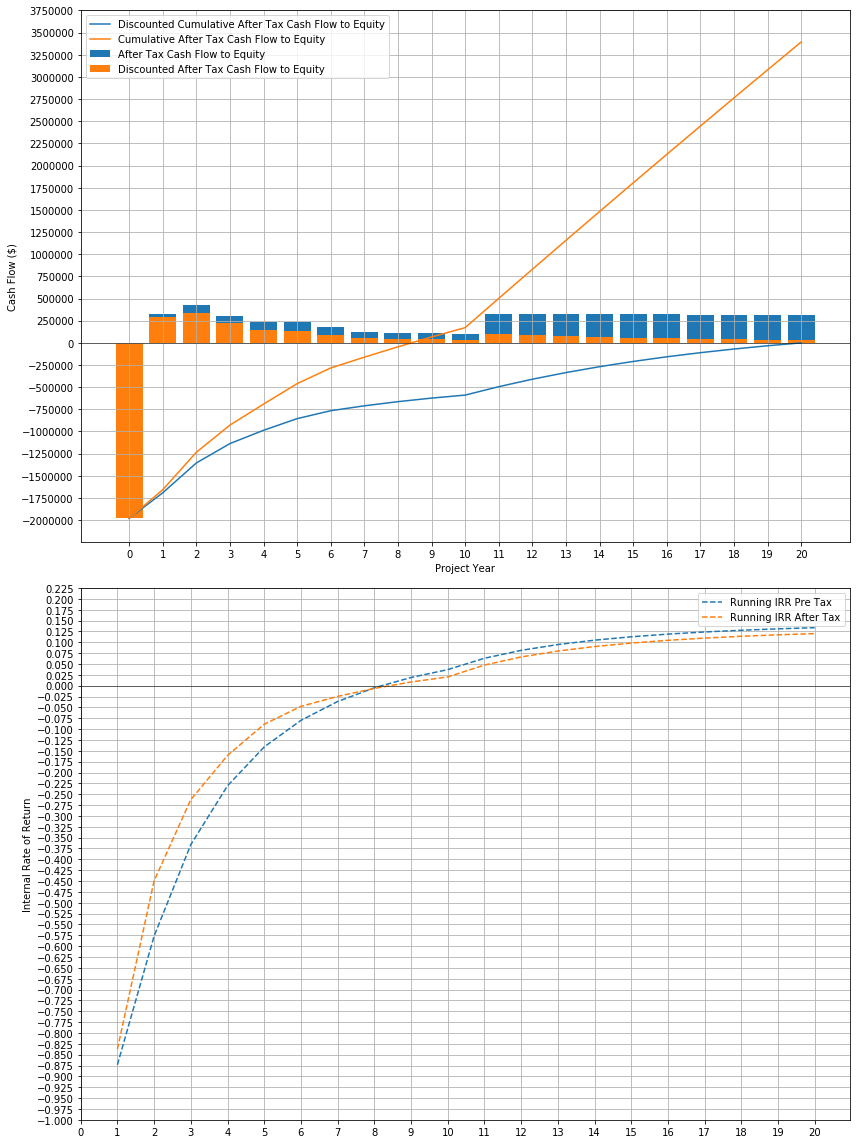

In [294]:
fig, ax = plt.subplots(2,1, figsize=(12,16))

ax[0].plot(proforma['Cumulative Discounted After Tax Cash Flow to Equity'], label='Discounted Cumulative After Tax Cash Flow to Equity')
ax[0].plot(proforma['Cumulative After Tax Cash Flow to Equity'], label='Cumulative After Tax Cash Flow to Equity')
ax[0].bar(range(len(proforma)) , proforma['After-Tax Cash Flow to Equity'], label='After Tax Cash Flow to Equity')
ax[0].bar(range(len(proforma)) , proforma['Discounted After Tax Cash Flow to Equity'], label='Discounted After Tax Cash Flow to Equity')

ax[0].set_ylabel('Cash Flow ($)')
ax[0].set_xlabel('Project Year')
ax[0].grid(True)
ax[0].axhline(0, color='k', linewidth=0.5)
ax[0].set_xticks(np.arange(0, 21, step=1))
ax[0].set_yticks(np.arange(-2000000, 4000000, step=250000))


# plt.yticks(np.arange(0, 4000000, step=10000))
ax[0].legend()

ax[1].plot(proforma['Running IRR Pre Tax'], '--', label='Running IRR Pre Tax')
ax[1].plot(proforma['Running IRR After Tax'], '--', label='Running IRR After Tax')
ax[1].set_ylabel('Internal Rate of Return')
ax[1].grid(True)
ax[1].axhline(0, color='k', linewidth=0.5)
ax[1].set_yticks(np.arange(-1.0, .25, step=0.025))
ax[1].set_xticks(np.arange(0, 21, step=1))
ax[1].legend()

fig.tight_layout()
plt.show()

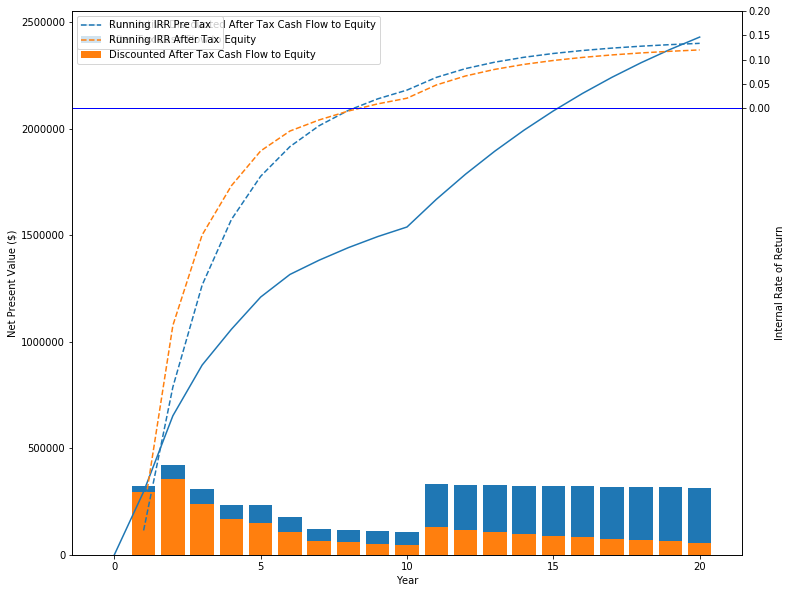

In [129]:
fig, ax = plt.subplots(figsize=(12,10))
# plt.axhline(0, color='r', linewidth=1)

ax.plot(proforma['Cumulative Discounted After Tax Cash Flow to Equity'], label='Cumulative Discounted After Tax Cash Flow to Equity')
ax.bar(range(len(proforma)) , proforma['After-Tax Cash Flow to Equity'], label='After Tax Cash Flow to Equity')
ax.bar(range(len(proforma)) , proforma['Discounted After Tax Cash Flow to Equity'], label='Discounted After Tax Cash Flow to Equity')

ax.set_ylabel('Net Present Value ($)')
ax.set_xlabel('Year')
ax.axhline(0, color='r', linewidth=1)

ax2=ax.twinx()
ax2.plot(proforma['Running IRR Pre Tax'], '--', label='Running IRR Pre Tax')
ax2.plot(proforma['Running IRR After Tax'], '--', label='Running IRR After Tax')
ax2.set_ylabel('Internal Rate of Return')
ax2.axhline(0, color='b', linewidth=1)

plt.yticks(np.arange(0, .25, step=0.05))

ax.legend()
ax2.legend()
plt.show()

##### Calculate NPV, IRR and Payback

In [78]:
# NPV to the Firm USE WACC, NPV to equity use cost of equity
def net_present_value(cashflow, rate):            
    spv_factors = [(1/(1 + rate)) ** i for i in range(0,project_life)]
    internal_rate_return = np.irr(cashflow*spv_factors)
    npv = (cashflow * spv_factors)
    npv_value = sum(npv)
    npv_value_check  = np.npv(rate, cashflow)
    cumulative_ebit = ebit.cumsum()
    cumulative_npv = npv.cumsum()
    financial_df = pd.DataFrame(cumulative_npv, columns=['CumulativeDiscountedCashFlows'])
    financial_df['DiscountedCashFlows'] = npv
    financial_df.index.name = 'Year'
    financial_df
    
    ## Payback period calculation
    final_full_year = financial_df[financial_df.CumulativeDiscountedCashFlows < 0].index.values.max()
    fractional_yr = -financial_df.CumulativeDiscountedCashFlows[final_full_year]/financial_df.DiscountedCashFlows[final_full_year + 1]
    payback_period = final_full_year + fractional_yr
    return(npv, npv_value, npv_value_check, internal_rate_return, cumulative_ebit, cumulative_npv, financial_df, payback_period)

In [78]:
# NPV to the Firm USE WACC, NPV to equity use cost of equity
def net_present_value(cashflow, rate):            
    spv_factors = [(1/(1 + rate)) ** i for i in range(0,project_life)]
    internal_rate_return = np.irr(cashflow*spv_factors)
    npv = (cashflow * spv_factors)
    npv_value = sum(npv)
    npv_value_check  = np.npv(rate, cashflow)
    cumulative_ebit = ebit.cumsum()
    cumulative_npv = npv.cumsum()
    financial_df = pd.DataFrame(cumulative_npv, columns=['CumulativeDiscountedCashFlows'])
    financial_df['DiscountedCashFlows'] = npv
    financial_df.index.name = 'Year'
    financial_df
    
    ## Payback period calculation
    final_full_year = financial_df[financial_df.CumulativeDiscountedCashFlows < 0].index.values.max()
    fractional_yr = -financial_df.CumulativeDiscountedCashFlows[final_full_year]/financial_df.DiscountedCashFlows[final_full_year + 1]
    payback_period = final_full_year + fractional_yr
    return(npv, npv_value, npv_value_check, internal_rate_return, cumulative_ebit, cumulative_npv, financial_df, payback_period)

In [78]:
# # NPV to the Firm USE WACC, NPV to equity use cost of equity
# def net_present_value(cashflow, rate):            
#     spv_factors = [(1/(1 + rate)) ** i for i in range(0,project_life)]
#     internal_rate_return = np.irr(cashflow*spv_factors)
#     npv = (cashflow * spv_factors)
#     npv_value = sum(npv)
#     npv_value_check  = np.npv(rate, cashflow)
#     cumulative_ebit = ebit.cumsum()
#     cumulative_npv = npv.cumsum()
#     financial_df = pd.DataFrame(cumulative_npv, columns=['CumulativeDiscountedCashFlows'])
#     financial_df['DiscountedCashFlows'] = npv
#     financial_df.index.name = 'Year'
#     financial_df
    
#     ## Payback period calculation
#     final_full_year = financial_df[financial_df.CumulativeDiscountedCashFlows < 0].index.values.max()
#     fractional_yr = -financial_df.CumulativeDiscountedCashFlows[final_full_year]/financial_df.DiscountedCashFlows[final_full_year + 1]
#     payback_period = final_full_year + fractional_yr
#     return(npv, npv_value, npv_value_check, internal_rate_return, cumulative_ebit, cumulative_npv, financial_df, payback_period)

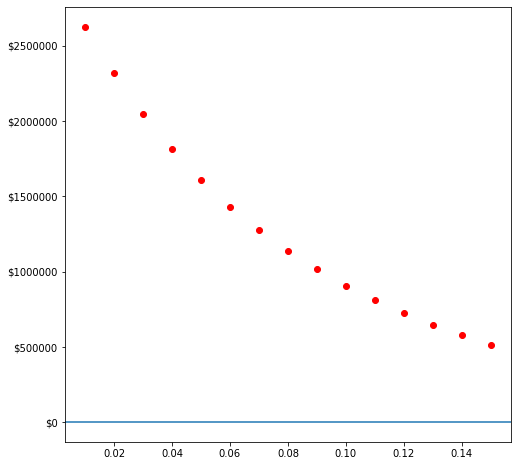

In [82]:
waccs = np.arange(0.01, .16, 0.01)
results = []
for i in waccs:
    values = net_present_value(free_cash_flow_firm, i)
    results.append(values)

fig, ax1 = plt.subplots(figsize=(8,8))
for i in range(len(waccs)):
    ax1.plot(waccs[i], results[i][1], 'or')

# ax2 = ax1.twinx()
# for i in range(len(waccs)):
#     ax2.plot(waccs[i], results[i][3], 'og')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax1.yaxis.set_major_formatter(formatter)

for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_visible(True)
    tick.label2.set_visible(False)
    tick.label1.set_color('k')

plt.axhline()
plt.show()

##### Print metrics and plot

In [19]:
# print('NPV to Firm (Using analytic solution):', round(npv_fcff[1],0))
# print('NPV CHECK (Using Numpy):', npv_fcff[2])
# print('IRR to Firm', npv_fcff[3])
# print('Discounted Payback = ', npv_fcff[7])

# plt.figure(figsize=(15,8))
# plt.bar(years, free_cash_flow_firm)
# plt.bar(years, npv_fcff[0])
# plt.plot(years, npv_fcff[4] , label='Cumulative Cashflow')
# plt.plot(years, npv_fcff[5], label='Cumulative NPV')
# plt.legend()
# plt.axhline(y=0, xmin=0, xmax=1)

NPV (Using analytic solution) = 1031202.5677065154
NPV CHECK (Using Numpy) =  1031202.5677065148
Discounted Payback =  8.514425646803838


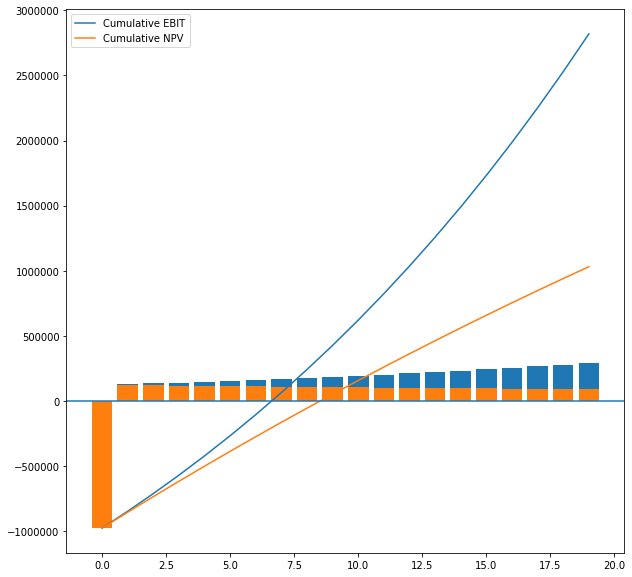

In [17]:
# Generate the model starting values
pv_cost=capacity_kw*unit_cost_power
om_cost = om_rate*capacity_kw
inverter_repl_cost = inverter_repl_rate*capacity_kw
principal = pv_cost
wacc = percent_debt*cost_of_debt*(1-corporate_tax_rate) + percent_equity*cost_of_equity

years = list(range(project_life))

capex = pd.Series(index=years)
capex[0] = pv_cost

savings = pd.Series(index=years)
savings[0] = capacity_kw * specific_yield * average_energy_rate

om = pd.Series(index=years)
om[0] = om_cost

# Calculate annual cost and benefit components

for year in range(1, project_life):
    savings[year] = savings[year - 1] * (1 + util_escalation_rate)
    om[year] = om[year - 1] * (1 + om_escalation_rate)
    capex[year] = capex[year - 1] * 0

# Combine cost and benefit components

costs = om
benefits = savings

#Calculate EBIT; note to self I dont know if i like capex here
#OR if I want to subtract capex in NPV formula
ebit = (benefits - costs) - capex

#Calculate the discount factors using the SPV method in this case
spv_factors = [(1/(1 + wacc)) ** i for i in range(0,project_life)]

npv = (ebit * spv_factors)
npv_value = sum(ebit * spv_factors)
npv_value_check  = np.npv(wacc, ebit)

cumulative_ebit = ebit.cumsum()
cumulative_npv = npv.cumsum()

financial_df = pd.DataFrame(cumulative_npv, columns=['CumulativeDiscountedCashFlows'])
financial_df['DiscountedCashFlows'] = npv
financial_df.index.name = 'Year'
financial_df

final_full_year = financial_df[financial_df.CumulativeDiscountedCashFlows < 0].index.values.max()
fractional_yr = -financial_df.CumulativeDiscountedCashFlows[final_full_year]/financial_df.DiscountedCashFlows[final_full_year + 1]
payback_period = final_full_year + fractional_yr
payback_period

print('NPV (Using analytic solution) =', npv_value)
print('NPV CHECK (Using Numpy) = ', npv_value_check)
print('Discounted Payback = ', payback_period)

plt.figure(figsize=(10,10))
plt.bar(years, ebit)
plt.bar(years, npv)
plt.plot(years, cumulative_ebit, label='Cumulative EBIT')
plt.plot(years, cumulative_npv, label='Cumulative NPV')
plt.legend()
plt.axhline(y=0, xmin=0, xmax=1)

In [4]:
# NOTES on the function that will be written from the tests below
# should the function calculate nper or should that come in from somewhere else
# consider calling pv_om something more generic but this may work for now
# consider changing range(len(nper)) to just range(years)
# Create a way to collect the cost and benefits for each technology

#IMPORT the model PARAMETERS
loan_years = 7
interest_rate = 0.04
payments_year = 1
capacity_kw = 100
unit_cost = 2000
inverter_repl_rate = 600
inverter_repl_year = 16
om_rate = 15
om_esc_rate = 0.03
lifetime = 20
landlease = 6500 
landlease_esc = 0.03
util_revenue = 81500
utility_esc = 0.03

# Generate the model starting values
pv_cost=capacity_kw*unit_cost
om_cost = om_rate*capacity_kw
inverter_repl_cost = inverter_repl_rate*capacity_kw
principal = pv_cost

In [29]:
ebit - capex

Year
0    -976250.000000
1     129442.500000
2     135394.875000
3     141618.930750
4     148127.007600
5     154932.004657
6     162047.405034
7     169487.302232
8     177266.427723
9     185400.179768
10    193904.653539
11    202796.672600
12    212093.821809
13    221814.481700
14    231977.864424
15    242604.051301
16    253714.032077
17    265329.745943
18    277474.124405
19    290171.136094
dtype: float64

In [12]:
ebitda_margin = 0.14
depr_percent = 0.032
ebitda = savings * ebitda_margin
depreciation = savings * depr_percent
ebit = ebitda - depreciation
nwc_percent = 0.24
nwc = savings * nwc_percent
change_in_nwc = nwc.shift(1) - nwc
capex_percent = depr_percent
capex = -(savings * capex_percent)
tax_rate = 0.25
tax_payment = -ebit * tax_rate
tax_payment = tax_payment.apply(lambda x: min(x, 0))
free_cash_flow = ebit + depreciation + tax_payment + capex + change_in_nwc
free_cash_flow
cost_of_capital = 0.12
terminal_growth = 0.02
terminal_value = ((free_cash_flow[-1] * (1 + terminal_growth))/(cost_of_capital - terminal_growth))
discount_factors = [(1/(1 + cost_of_capital)) ** i for i in range(1,6)]
dcf_value = (sum(free_cash_flow[1:] * discount_factors) + terminal_value * discount_factors[-1])

dcf_value

In [24]:
nwc

2018A     7.440000
2019B     8.184000
2020P     9.002400
2021P     9.902640
2022P    10.892904
2023P    11.982194
dtype: float64

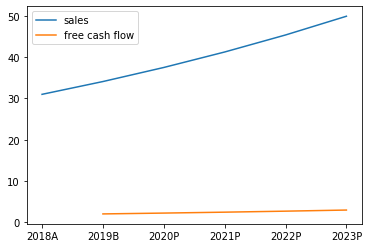

In [18]:
plt.plot(sales, label='sales')
plt.plot(free_cash_flow, label='free cash flow')
plt.legend()

In [115]:
# Key inputs from DCF model
# All values in $k
years = 10
starting_sales = 50.0
capex_percent = depr_percent = 0.032
sales_growth = 0.025
ebitda_margin = 0.14
nwc_percent = 0.24
tax_rate = 0.21
# DCF assumptions
# cost of capital
r = 0.12
# terminal growth rate
g = 0.02
# For MCS model
iterations = 1000
sales_std_dev = 0.01
ebitda_std_dev = 0.02
nwc_std_dev = 0.01

def run_mcs():
    
    # Generate probability distributions
    sales_growth_dist = np.random.normal(loc=sales_growth, 
                                         scale=sales_std_dev, 
                                         size=(years, iterations))
    ebitda_margin_dist = np.random.normal(loc=ebitda_margin, 
                                          scale=ebitda_std_dev, 
                                          size=(years, iterations))
    nwc_percent_dist = np.random.normal(loc=nwc_percent, 
                                        scale=nwc_std_dev, 
                                        size=(years, iterations))
    
    # Calculate free cash flow
    sales_growth_dist += 1
    for i in range(1, len(sales_growth_dist)):
        sales_growth_dist[i] *= sales_growth_dist[i-1]
    
    sales = sales_growth_dist * starting_sales
    ebitda = sales * ebitda_margin_dist
    ebit = ebitda - (sales * depr_percent)
    tax = -(ebit * tax_rate)
    np.clip(tax, a_min=None, a_max=0)
    nwc = nwc_percent_dist * sales
    starting_nwc = starting_sales * nwc_percent
    prev_year_nwc = np.roll(nwc, 1, axis=0)
    prev_year_nwc[0] = starting_nwc
    delta_nwc = prev_year_nwc - nwc
    capex = -(sales * capex_percent)
    free_cash_flow = ebitda + tax + delta_nwc + capex
    # Discount cash flows to get DCF value
    terminal_value = free_cash_flow[-1] * (1 + g) / (r - g)
    discount_rates = [(1 / (1 + r)) ** i for i in range (1, years + 1)]
    dcf_value = sum((free_cash_flow.T * discount_rates).T) 
    dcf_value += terminal_value * discount_rates[-1]
        
    return dcf_value

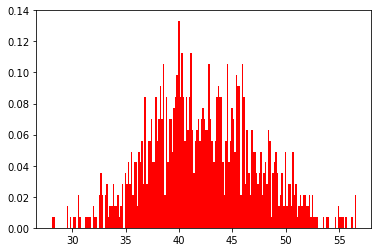

In [116]:
plt.hist(run_mcs(), bins=200, density=True, color="r")
plt.show()

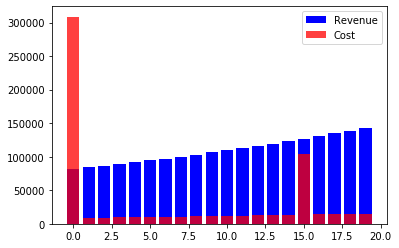

In [101]:
# Calculate the CAPEX, OPEX and REVENUE lists
fixed_om_pmt = annual_ compound(om_cost, om_esc_rate, lifetime)
lease_pmt = annual_compound(landlease, landlease_esc, lifetime)
capex_pmt = non_recurring_cost(lifetime, 1, capex)
inverter_repl_pmt = non_recurring_cost(lifetime, inverter_repl_year, inverter_repl_cost)
df=amortization_table(interest_rate, loan_years, payments_year, principal)
util_savings = annual_compound(util_revenue, utility_esc, lifetime)



# PV Cost, pv_cost, are the cost associated with PV system investment and operations.
# I am doing addition of lists. The lists therefore all need to be the same length
# The length of the lists is lifetime long
# These are the real costs and not discounted
# I will do a discounted version separately
# AGGREGATE Cost components and Revenue components
 

revenue = util_savings

cost = [capex_pmt[i] 
        + fixed_om_pmt[i] 
        + lease_pmt[i] 
        + inverter_repl_pmt[i] 
        for i in range(lifetime)]

ebit = [revenue[i] - cost[i] for i in range(lifetime)]


# PLot cost; can also plot each cost and stack bars might mike sense to do it on a percentage contribution basis
plt.bar(range(lifetime), revenue, color='b', label='Revenue')
plt.bar(range(lifetime), cost, color='red', alpha=0.75, label='Cost')

plt.legend()

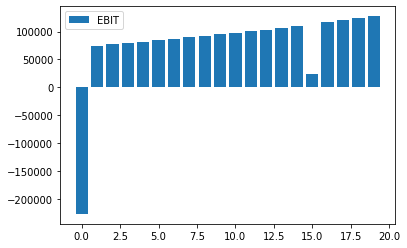

In [104]:
plt.bar(range(lifetime), ebit, label='EBIT')
plt.legend()

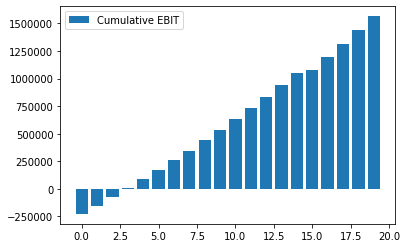

In [106]:
plt.bar(range(lifetime), np.cumsum(ebit), label='Cumulative EBIT')
plt.legend()

In [11]:
# this section creates the discounted cumulative O&M cost we need to do this eventually for the sake of plotting
# the NPV on an annual basis to visually show when we get payback and breakeven

disc_rate=0.07
pv_om_disc=[]
for i in range(lifetime):
    value = om_rate*capacity_kw
    val = mupv(value, disc_rate, esc_rate, i)
    pv_om_disc.append(val)

NameError: name 'esc_rate' is not defined

In [11]:
#O&M Categories
# O&M ($/wDC)
# Tax PILOT ($)
# Insurance - Phys Damage & BI ($)
# Insurance - General Liability ($)
# Internet Fees ($)
# Monitoring Software Fees ($)
# Distributed Generation Meter Charge ($)
# Inverter Replacement ($/wDC)
# Misc Annual Expense ($/wDC)
# Misc Annual Expense (per annum)
# Misc One-Time Expense ($/wDC)


In [ ]:

# def amortization_table(interest_rate, loan_yrs, pmt_yr, principal, addl_principal=0, start_date=dtm.date.today()):
#     """ Calculate the amortization schedule given the loan details
    
#      Args:
#         interest_rate: The annual interest rate for this loan
#         years: Number of years for the loan
#         pmt_yr: Number of payments in a year
#         principal: Amount borrowed
#         addl_principal (optional): Additional payments to be made each period. Assume 0 if nothing provided.
#                                    must be a value less then 0, the function will convert a positive value to
#                                    negative
#         start_date (optional): Start date. Will start on first of next month if none provided

#     Returns:
#         schedule: Amortization schedule as a pandas dataframe
#         summary: Pandas dataframe that summarizes the payoff information
#     """
#     # Ensure the additional payments are negative
#     if addl_principal > 0:
#         addl_principal = -addl_principal
    
#     # Create an index of the payment dates
#     rng = pd.date_range(start_date, periods=loan_yrs * pmt_yr, freq='MS')
#     rng.name = "Payment_Date"
    
#     # Build up the Amortization schedule as a DataFrame
#     df = pd.DataFrame(index=rng,columns=['Payment', 'Principal', 'Interest', 
#                                          'Addl_Principal', 'Curr_Balance'], dtype='float')
    
#     # Add index by period (start at 1 not 0)
#     df.reset_index(inplace=True)
#     df.index += 1
#     df.index.name = "Period"
    
#     # Calculate the payment, principal and interests amounts using built in Numpy functions
#     per_payment = np.pmt(interest_rate/pmt_yr, loan_yrs*pmt_yr, principal)
#     df["Payment"] = per_payment
#     df["Principal"] = np.ppmt(interest_rate/pmt_yr, df.index, loan_yrs*pmt_yr, principal)
#     df["Interest"] = np.ipmt(interest_rate/pmt_yr, df.index, loan_yrs*pmt_yr, principal)
        
#     # Round the values
#     df = df.round(2) 
    
#     # Add in the additional principal payments
#     df["Addl_Principal"] = addl_principal
    
#     # Store the Cumulative Principal Payments and ensure it never gets larger than the original principal
#     df["Cumulative_Principal"] = (df["Principal"] + df["Addl_Principal"]).cumsum()
#     df["Cumulative_Principal"] = df["Cumulative_Principal"].clip(lower=-principal)
    
#     # Calculate the current balance for each period
#     df["Curr_Balance"] = principal + df["Cumulative_Principal"]
    
#     # Determine the last payment date
#     try:
#         last_payment = df.query("Curr_Balance <= 0")["Curr_Balance"].idxmax(axis=1, skipna=True)
#     except ValueError:
#         last_payment = df.last_valid_index()
    
#     last_payment_date = "{:%m-%d-%Y}".format(df.loc[last_payment, "Payment_Date"])
        
#     # Truncate the data frame if we have additional principal payments:
#     if addl_principal != 0:
                
#         # Remove the extra payment periods
#         df = df.loc[0:last_payment].copy()
        
#         # Calculate the principal for the last row
#         df.loc[last_payment, "Principal"] = -(df.loc[last_payment-1, "Curr_Balance"])
        
#         # Calculate the total payment for the last row
#         df.loc[last_payment, "Payment"] = df.loc[last_payment, ["Principal", "Interest"]].sum()
        
#         # Zero out the additional principal
#         df.loc[last_payment, "Addl_Principal"] = 0
        
#     # Get the payment info into a DataFrame in column order
#     payment_info = (df[["Payment", "Principal", "Addl_Principal", "Interest"]]
#                     .sum().to_frame().T)
       
#     # Format the Date DataFrame
#     payment_details = pd.DataFrame.from_dict(dict([('payoff_date', [last_payment_date]),
#                                                ('Interest Rate', [interest_rate]),
#                                                ('Number of years', [loan_yrs])
#                                               ]))
#     # Add a column showing how much we pay each period.
#     # Combine addl principal with principal for total payment
#     payment_details["Period_Payment"] = round(per_payment, 2) + addl_principal
    
#     payment_summary = pd.concat([payment_details, payment_info], axis=1)
    
#     return df, payment_summary

In [27]:
# decide if I should pass the value that is to be escalated or just generate the list of esclation or present_value factors
# that I can multiply by a constant like YR1 O&M cost and get the PV of it
def compound(principal, interest, nper):
    return(principal*(1+interest)**nper)

def annual_compound(rate, esc, lifetime):
    annual_val = []
    for i in range(lifetime):
        val = compound(rate, esc, i)
        annual_val.append(val)
    return(annual_val)

def spv(value, discount, nper):
    '''
    Single Present Value factor is used to calculate
    the present value of a future cash amount occuring
    at the end of the year
    
    value = future value
    discount = discount rate
    nper = number of years
    '''
    return(value/(1+discount)**nper)

def upv(value, discount, nper):
    '''
    Uniform Present Value is used to calculate the
    present value of a series of equal cash amounts
    that recur annually over a period of nper years
    given a discount rate.
    
    value = the equal cash amounts per year
    discount = discount rate
    nper = number of years
    
    '''
    return(value*(((1+discount)**nper)-1)/(discount*(1+discount)**nper))

def mupv(discount, escalation, nper):
    '''
    Modified Uniform Present Value is used to calculate the
    present value of recurring annual amounts that change from 
    year to year at a constant escalation rate over nper years
    given an discount rate.
    
    value = initial cash amount
    discount = discount rate
    escalation = the rate at which the initial amount escalates
    nper = number of years
    '''
    return(((1+escalation)/(discount-escalation))*(1-((1+escalation)/(1+discount))**nper))

def non_recurring_cost(lifetime, year, value):
    cost_list = [0]*lifetime
    year_of_cost = year-1
    cost_list[year_of_cost] = value
    return(cost_list)



def loan_calc(principal, rate, payment):
    """
    Generator that yields successive period payment details
    """
    amount = payment
    while principal > 0:
        period_interest = principal * rate
        principal_reduction = min(principal, amount - period_interest)
        principal = principal - principal_reduction
        yield principal_reduction, period_interest, principal
        
def amortization_table(interest_rate, project_lifetime, loan_years, payments_year, principal):
    """
    Calculate the amortization schedule given the loan details


    :param interest_rate: The annual interest rate for this loan
    :param years: Number of years for the loan
    :param payments_year: Number of payments in a year
    :parma principal: Amount borrowed

    :return: 
        schedule: Amortization schedule as a pandas dataframe
    """
    #Calculate the fixed payment 
    period_rate = interest_rate/payments_year
    payment = -1 * np.pmt(period_rate, loan_years*payments_year, principal)

    #Generate the period details schedule

    df = pd.DataFrame(list(loan_calc(principal, period_rate, payment)), columns=["Principal", "Interest", "Balance"])
    df["Total Payment"] = df["Principal"] + df["Interest"]
    df["Cummulative Principal"] = df["Principal"].cumsum()
    
    index = np.arange(df.index.stop*payments_year, project_lifetime*payments_year)
    df2 = pd.DataFrame(index=index) 
    df = pd.concat([df,df2], axis=1).fillna(0)
    df=df.round(2)
    return(df)

In [29]:
amortization_table(0.07, 20, 18, 1, 3150000)

,Principal,Interest,Balance,Total Payment,Cummulative Principal
0,92649.70,220500.00,3057350.30,313149.7,92649.70
1,99135.17,214014.52,2958215.13,313149.7,191784.87
2,106074.64,207075.06,2852140.49,313149.7,297859.51
3,113499.86,199649.83,2738640.63,313149.7,411359.37
4,121444.85,191704.84,2617195.78,313149.7,532804.22
5,129945.99,183203.70,2487249.79,313149.7,662750.21
6,139042.21,174107.49,2348207.58,313149.7,801792.42
7,148775.16,164374.53,2199432.42,313149.7,950567.58
8,159189.43,153960.27,2040242.99,313149.7,1109757.01
9,170332.69,142817.01,1869910.31,313149.7,1280089.69


In [22]:
# NPV to the Firm USE WACC
spv_factors = [(1/(1 + wacc)) ** i for i in range(0,project_life)]

npv = (ebit * spv_factors) - capex
npv_value = sum(npv)
npv_value_check  = np.npv(wacc, ebit) - capex

cumulative_ebit = ebit.cumsum()
cumulative_npv = npv.cumsum()

financial_df = pd.DataFrame(cumulative_npv, columns=['CumulativeDiscountedCashFlows'])
financial_df['DiscountedCashFlows'] = npv
financial_df.index.name = 'Year'
financial_df

final_full_year = financial_df[financial_df.CumulativeDiscountedCashFlows < 0].index.values.max()
fractional_yr = -financial_df.CumulativeDiscountedCashFlows[final_full_year]/financial_df.DiscountedCashFlows[final_full_year + 1]
payback_period = final_full_year + fractional_yr

In [115]:
# NPV to the Firm USE WACC
spv_factors = [(1/(1 + wacc)) ** i for i in range(0,project_life)]

irr_to_firm = round(np.irr(free_cash_flow_firm), 5)

npv = (free_cash_flow_firm * spv_factors)
npv_value = sum(npv)
npv_value_check  = np.npv(wacc, free_cash_flow_firm)

cumulative_ebit = ebit.cumsum()
cumulative_npv = npv.cumsum()

financial_df = pd.DataFrame(cumulative_npv, columns=['CumulativeDiscountedCashFlows'])
financial_df['DiscountedCashFlows'] = npv
financial_df.index.name = 'Year'
financial_df

final_full_year = financial_df[financial_df.CumulativeDiscountedCashFlows < 0].index.values.max()
fractional_yr = -financial_df.CumulativeDiscountedCashFlows[final_full_year]/financial_df.DiscountedCashFlows[final_full_year + 1]
payback_period = final_full_year + fractional_yr

In [17]:
# ebitda = revenue - opex

# ebit = revenue - opex - depreciation

# ebt = revenue - opex - depreciation - interest

# net_earnings =  revenue - opex - depreciation - interest - fed_tax

# cash_from_operations = net_earnings + depreciation

# cash_flow = cash_from_operations

# free_cash_flow = net_earnings + depreciation - capex

# free_cash_flow_equity = net_earnings + depreciation - capex - principal

# fed_tax_ebit = ((ebit) * corporate_tax_rate)
# np.clip(fed_tax_ebit, a_min=0, a_max=None)

# free_cash_flow_firm = ebit - fed_tax_ebit + depreciation - capex

In [12]:
# def loan_calc(principal, rate, payment):
#     """
#     Generator that yields successive period payment details
#     """
#     amount = payment
#     while principal > 0:
#         period_interest = principal * rate
#         principal_reduction = min(principal, amount - period_interest)
#         principal = principal - principal_reduction
#         yield principal_reduction, period_interest, principal
        
# def amortization_table(interest_rate, project_life, loan_years, payments_year, principal):
#     """
#     Calculate the amortization schedule given the loan details


#     :param interest_rate: The annual interest rate for this loan
#     :param years: Number of years for the loan
#     :param payments_year: Number of payments in a year
#     :parma principal: Amount borrowed

#     :return: 
#         schedule: Amortization schedule as a pandas dataframe
#     """
#     #Calculate the fixed payment 
#     period_rate = interest_rate/payments_year
#     payment = -1 * np.pmt(period_rate, loan_years*payments_year, principal)

#     #Generate the period details schedule

#     df = pd.DataFrame(list(loan_calc(principal, period_rate, payment)), columns=["Principal", "Interest", "Balance"])
#     df["Total Payment"] = df["Principal"] + df["Interest"]
#     df["Cummulative Principal"] = df["Principal"].cumsum()
    
#     index = np.arange(payments_year, project_life*payments_year)
#     df2 = pd.DataFrame(index=index) 
#     df = pd.concat([df,df2], axis=1).fillna(value=0)
#     df=df.round(2)
#     return(df)

In [5]:
# pv_generation = pd.Series(index=years)
# pv_generation[0] = pv_capacity_kw*capacity_factor*8760
# for year in range(1, project_life):
#     pv_generation[year] = pv_generation[year - 1] * (1 + pv_degradation_rate)

| This | is   |asdfasd|
|-|||
|   a  | table|asdfasdf|

# Energy Project Analysis

In this article I will cover key concepts for comparing alternative investments. When evaluating alternative investments in energy projects there are a few decision criteria that managers can use to facilitate their decision. The most common metrics are net present value and internal rate of return. Importantly, even with the "perfect" set of objective financial metrics there are, in many cases, non-quantifiable and intangible requirements or benefits. In some cases these intangibles can drive a stakeholder to choose a less economically favorable project to ensure those other criteria are met. Nonetheless I will be stepping through what I would call the fundamentals of energy project valuation in this article.

This post will be cover the following:
* Develop a framework for identifying alternatives and making decisions
* Discounted Cash Flow (DCF) method
* Definition of key terms and equations used in the DCF analysis
* Benefit-Cost Index
* Levelized Cost of Energy

The **Corporate Finance Institute** describes the investment decision process as such:

*Thorough investment analysis requires an analyst to examine both the net present value (NPV) and the internal rate of return, along with other indicators, such as the payback period, in order to select the right investment.  Since it’s possible for a very small investment to have a very high rate of return, investors and managers sometimes choose a lower percentage return but higher absolute dollar value opportunity. Also, it’s important to have a good understanding of your own risk tolerance, or a company’s investment needs, risk aversion, and other available options.*

### Key Takeaways

Before getting to the contents of this post I will tell you the spoilers:

* Discounted Cash Flow method is the method of choice for energy project analysis - from this we determine the Net Present Value, IRR and Benefit-Cost-Index, Levelized Cost of Energy and Payback period

* We use the NPV to evaluate if a project is worth the investment, it must be greater than zero.

* Payback period is not an ideal investment criteria by itself and fails in many ways at conveying a projects true value

* When comparing alternative investments we can compare NPV of each project all else being equal and pick the one with the highest NPV.

* When comparing alternative investments where all things are not equal we can use the NPV in conjunction with IRR and other metrics like Benefit-Cost ratio or the payback period along with other non-quantifiable investment criteria to judge which investment is most suitable.

* There is no analytic solution for optimizing IRR only numerical, iterative or sensitivity analyses.

* If a manager tells you they need an IRR of 8% you can use that 8% as the discount rate in the NPV formula and calculate the NPV and determine the associated payback period. With the discount rate equal to the IRR you can run a sensitivity analysis on various system sizes or costs and calculate the NPV's and paybacks and then rank them.

* The point at which the NPV goes from negative to positive is the payback year; this point also determines the IRR

* Know which discount rate to use in the NPV depending on who you are talking to - more on this in the post

* We use real dollars and real rates, we don't adjust for inflation

* In a linear program if you are trying to solve for the highest NPV, IRR you have to iterate through each new system size or costs, simulate, and repeat.

# 1 Discounted Cash Flow
Discounted cash flow (DCF) analysis is a method of valuing an investment by applying the concept of the time value of money. The process of determining the value of an investment is carried out by projecting future cash flow returns and translating those future returns into today's dollars. The translation of future dollars to today's dollars is called discounting. The DCF method and Net Present Value (NPV) are synonymous.

### 1.1 How To Calculate Discounted Cash Flows

To calculate discounted cash flows you first calculate the Present Value (PV) of each individual cash inflow or outflow of a project. In an energy project we usually have project revenues in terms of savings generated through the operation of onsite distributed energy resources (DERs) or through the sale of energy products and we treat these as cash inflows. Cash outflows are associated with the energy projects operations and maintenance and debt service. The shorthand terms that I like to use are benefits and costs. To calculate NPV we take the sum of the present value of the benefits (+) and costs (-).

# 2 Present Value

The present value method allows analysts to convert benefits and costs that occur at different time intervals to their current value. We can therefore talk about the value of benefits and costs as if the occured today. Investments made today begin to earn interest immediately and if a dollar recieved in the future is not re-invested it cannot earn interest. 

The present value concept assumes these principles:
* Benefits that accrue in the future are worth less than the same benefits that accrue today
* Costs that accrue in the future are less honerous than those that occur today
* The difference between a dollar invested today and a dollar invested in the future is the interest earned on the dollar invested today.

To calculate the present value we multiply the costs and benefits by the discount factor which is sometimes referred to as the opportunity cost of capital. To compute the discount factor we need to know the discount rate and the investment lifespan.

**Key Points**

- When we talk about the process of calculating the present value we are talking about discounting.
- The discount factor does in fact depend on when the values occur throughout a given year. The discount factors comes in the following options:
* End-of-year factor - as the name implies it assumes that a value occurs at the end of the year
* Average factor - this assumes that values occur more evenly throughout the year, perhaps monthly. This is often the default assumption for most energy projects.

How do you know when to use any one of the factors?

* Use the average factor when you are sure that the cost occur evenly throughout a year
* Use the "end-of-year" when you dont know when the value accrues and/or if it happens at the end of a year

### 2.1 Single Present Value (SPV)


Single Present Value factor is used to calculate the present value of a future cash amount occuring at the end of the year. This is the most common present value equation and widely used as in the NPV calculation.

$$ PV = \frac{FV}{(1 + d)^t} $$

$FV$ = future value\
$d$ = discount rate\
$t$ = number of years


### 2.2 Uniform Present Value (UPV)

Uniform Present Value is used to calculate the present value of a series of equal cash amounts
that recur annually over a period of nper years given a discount rate.

$$ PV = A_0 \frac{(1+d)^t - 1}{d(1 + d)^t} $$

    
$A_0$ = the equal cash amounts per year\
$d$ = discount rate\
$t$ = number of years

### 2.3 Modified Uniform Present Value (MUPV)

Modified Uniform Present Value is used to calculate the present value of non-recurring annual amounts that change from year to year at a constant escalation rate over nper years given an discount rate.

$$ PV = A_0 \frac{1+e}{d-e} \left[1-\left( \frac{1 + e}{1+d}\right)^t \right] $$

$A_0$ = initial cash amount\
d = discount rate\
e = escalation rate\
t = number of years

# 3 Net Present Value (NPV)

The net present value method yields a number in todays dollars that can be compared with the initial investment and to gauge the amount of value a projects delivers over time. When a manager needs to make a decision on alternative investments the net present value is very straight forward, all else being equal, pick the alternative with highest NPV.

For economic and financial studies NPV is a key tool for analyst and decisions makers alike because it considers the time value of money, and its result (the NPV) can be compared against the cost of the initial investment.

NPV is the summation of the present value of a series of future cashflows (outflows and inflows) generated by an investment with discount. NPV is defined by the following equation:

$$ NPV = \sum_{t=0}^T \frac{C_{t}}{(1+r)^t} $$

$r$ = discount rate\
$t$ = number of periods or years\
$C$ = the cash flow during each period

When NPV is zero a number of key metrics fall out from the calculation, like breakeven, payback and its the point where you have met the required rate of return, wether that is the minimum IRR required, WACC, cost equity.

Once the benefits and costs have been reduced to their present value equivalent per the equations in the Present Value section you can calculate the Net Present Value (NPV) by finding the difference between benefits and costs. We do not include the initial project cost in the present value calculations and instead subtract it to find the NPV.

$$ NPV = \sum_{n=0}^T \frac{C_{t}}{(1+r)^t} = 0$$

$$ NPV = PV_{benefits} - PV_{costs} - CAPEX $$

where

$PV_{benefits} = $ present value of benefits\
$PV_{costs} = $ present value of costs

### 3.1  Key Concepts on NPV

When financing an energy project the most relevant forms of capital are supplied through debt and equity. Ideally, the investment has to create a value sufficient enough to gain support from the stakeholders typically the debt holders and to provide adequate remuneration to the equity investor. Realistic financial models consider three types of NPV:

**NPV for economic studies:**
This is the “traditional” NPV used in economic studies as it does not consider taxes or how the finance is divided between equity and debt. This indicator only considers the cost aspect or the outbound cashflow. This NPV is useful for engineers and policymakers to calculate the LCOE and electricity price to break-even, since the LCOE is the average minimum price at which the electricity must be sold (at lifetime) for the project to breakeven. **The cash flow is discounted at WACC**.

**NPV to equity holders:**
This is the sum of the levered cashflows; we consider debt. Specifically, the equity can be determined by discounting the “free cashflow to the equity” at equity cost. It is the NPV from the perspective of the equity holders, e.g., consider the payment of taxes and the repayment of debt/interest to debt holders. The equity holders receive a remuneration equal to the cost of equity if the NPV is zero. **The cash flow is discounted at cost of equity**

**NPV to the firm:**
This is the “free cashflow to the firm” or the sum of the unlevered cashflows; debt is not taken out. Debtholders may consider financing the project if the NPV is larger than zero. This signifies the investment generates enough value to payoff the debt. With respect to the “NPV for economic studies”, this NPV considers the taxes and the financial structure of the investment. **The cash flow is discounted at WACC**

* In the first years the NPV is likely negative
* Break-even is when NPV is zero
* Payback period is the time it takes to reach break-even
* Plotting presenting value of costs and benefits one can easily identify break-even and payback
* Plot the CUMULATIVE NPV at the end of each year to compare alternative

# 4 Internal Rate of Return (IRR)
The internal rate of return is the discount rate that makes NPV zero.
Under the hood we are looking for the rate that induces the break-even between the initial investment and future cashflows.

Once the IRR of the project has been determined it can be compared to the investors cost of capital or hurdle rate. If the IRR meets or exceeds the hurdle rate it should be considered in light of other investment criteria (as mentioned in other sections investment decisions are rarely based on a single metric).

There is no analytic solution for IRR. There are only numerical solutions. Analytic solutions are exact and obtained by methods of symbolic manipulation. Numerical solutions yield approximations of the solution. For all practical purpose, the numerical solution can be made very close to the analytic and achieve results that are appropriate energy project analysis. However it is usually more effective to and instructive to perform a sensitivity analysis to understand how the IRR is effected by other variables in the economic model.

In this case, solving for IRR via the NPV formula, a common approach is the Newton-Raphson numerical method.


# 5 Weighted Average Cost of Capital (WACC)

$$ WACC =  DK_{d}(1-t) + EK_{e} $$

$D$ = debt ratio \
$E$ = equity ratio \
$K_{d}$ = cost of debt \
$K_{e}$ = cost of equity \
$t$ = corporate tax rate

### 5.1 Cost of Capital vs. Cost of Equity: An Overview *

A company's cost of capital refers to the cost that it must pay in order to raise new capital funds, while its cost of equity measures the returns demanded by investors who are part of the company's ownership structure.

Cost of equity is the percentage return demanded by a company's owners, but the cost of capital includes the rate of return demanded by lenders and owners.

KEY TAKEAWAYS
* The cost of capital refers to what a corporation has to pay so that it can raise new money.

* The cost of equity refers to the financial returns investors who invest in the company expect to see.

#### 5.1.1 Cost of Capital

Publicly-listed companies can raise capital by borrowing money or selling ownership shares. Debt investors and equity investors require a return on their money, either through interest payments or capital gains/dividends. The cost of capital takes into account both the cost of debt and the cost of equity.

Stable, healthy companies have consistently low costs of capital and equity. Unpredictable companies are riskier, and creditors and equity investors require higher returns on their investments to offset the risk.

For bondholders and other lenders, this higher return is easy to see; the rate of interest charged on debt is higher. It is more difficult to calculate the cost of equity since the required rate of return for stockholders is less clearly defined.

#### 5.1.2 Cost of Equity

A company's cost of equity refers to the compensation the financial markets require in order to own the asset and take on the risk of ownership.

One way that companies and investors can estimate the cost of equity is through the capital asset pricing model (CAPM). To calculate the cost of equity using CAPM, multiply the company's beta by its risk premium and then add that value to the risk-free rate. In theory, this figure approximates the required rate of return based on risk.

A more traditional way of calculating the cost of equity is through the dividend capitalization model, wherein the cost of equity is equal to the dividends per share divided by the current stock price, which is added to the dividend growth rate.

###### * Source: https://www.investopedia.com/ask/answers/013015/what-difference-between-cost-equity-and-cost-capital.asp

# 6 Benefit-Cost Index (BCI)

The benefit-cost index is simply the present value benefits divided by the present value of costs. It tells us the amount of benefit we get for each dollar spent.

$$BCI = \frac{PV_{benefits}}{PV_{cost}}$$

For example:

An investment whose present value benefit is $1,000,000 and whose present value costs are $835,000 would have a BCI of 1.197, which is derived from $$ \frac{$1,000,000}{$835,000} $$

The benefit-cost-ratio means that for each dollar invested the investor should expect to recieve \\$1.197 back in benefits over time. This metric shows which alternative provides the largest return relative to costs.

# 7 Adjusting for Inflation

Inflation has the effect of reducing the purchasing power of a dollar in the future. Conversely deflation has the opposite effect.

## 7.1 Current dollars (nominal)
Current dollars are inclusive of inflation, current dollars reflect the changes in purchasing power of the dollar from year to year.

When we work in current dollars we use the term "nomimal" to denote that the value in question is inclusive of inflation. For example, nominal discount rate is inflation adjusted.

If you know the interest rate and the real discount rate the nominal discount rate is:
$$ D = (1 + I)(1 + d) - 1 $$

## 7.2 Constant dollars (real)
Constant dollars are exclusive of inflation. Constant dollars express uniform purchasing power, constant dollars indicate that the value is unchanging over time.

When we work in constant dollars we use the term "real" to denote that the value in question is exclusive of inflation. For example, real discount rate is not inflation adjusted.

Discount rates are typically expressed terms of market interest rates. Market interest rates in turn are nominal and serve as the basis for the selection of a nominal discount rate which is used to discount future costs expressed in current dollars.

If given the nominal discount rate and rate of inflation the real discount rate is:
$$ d = \frac{1+D}{1+I} - 1 $$


## 7.3 How does inflation or deflation differ from discounting

Inflation and deflation adjusts for the purchasing power of the dollar whereas discounting adjusts for the investors time-value of money.


**Unlevered Net Income**
    
    Net Income Unlevered = EBIT - Tax